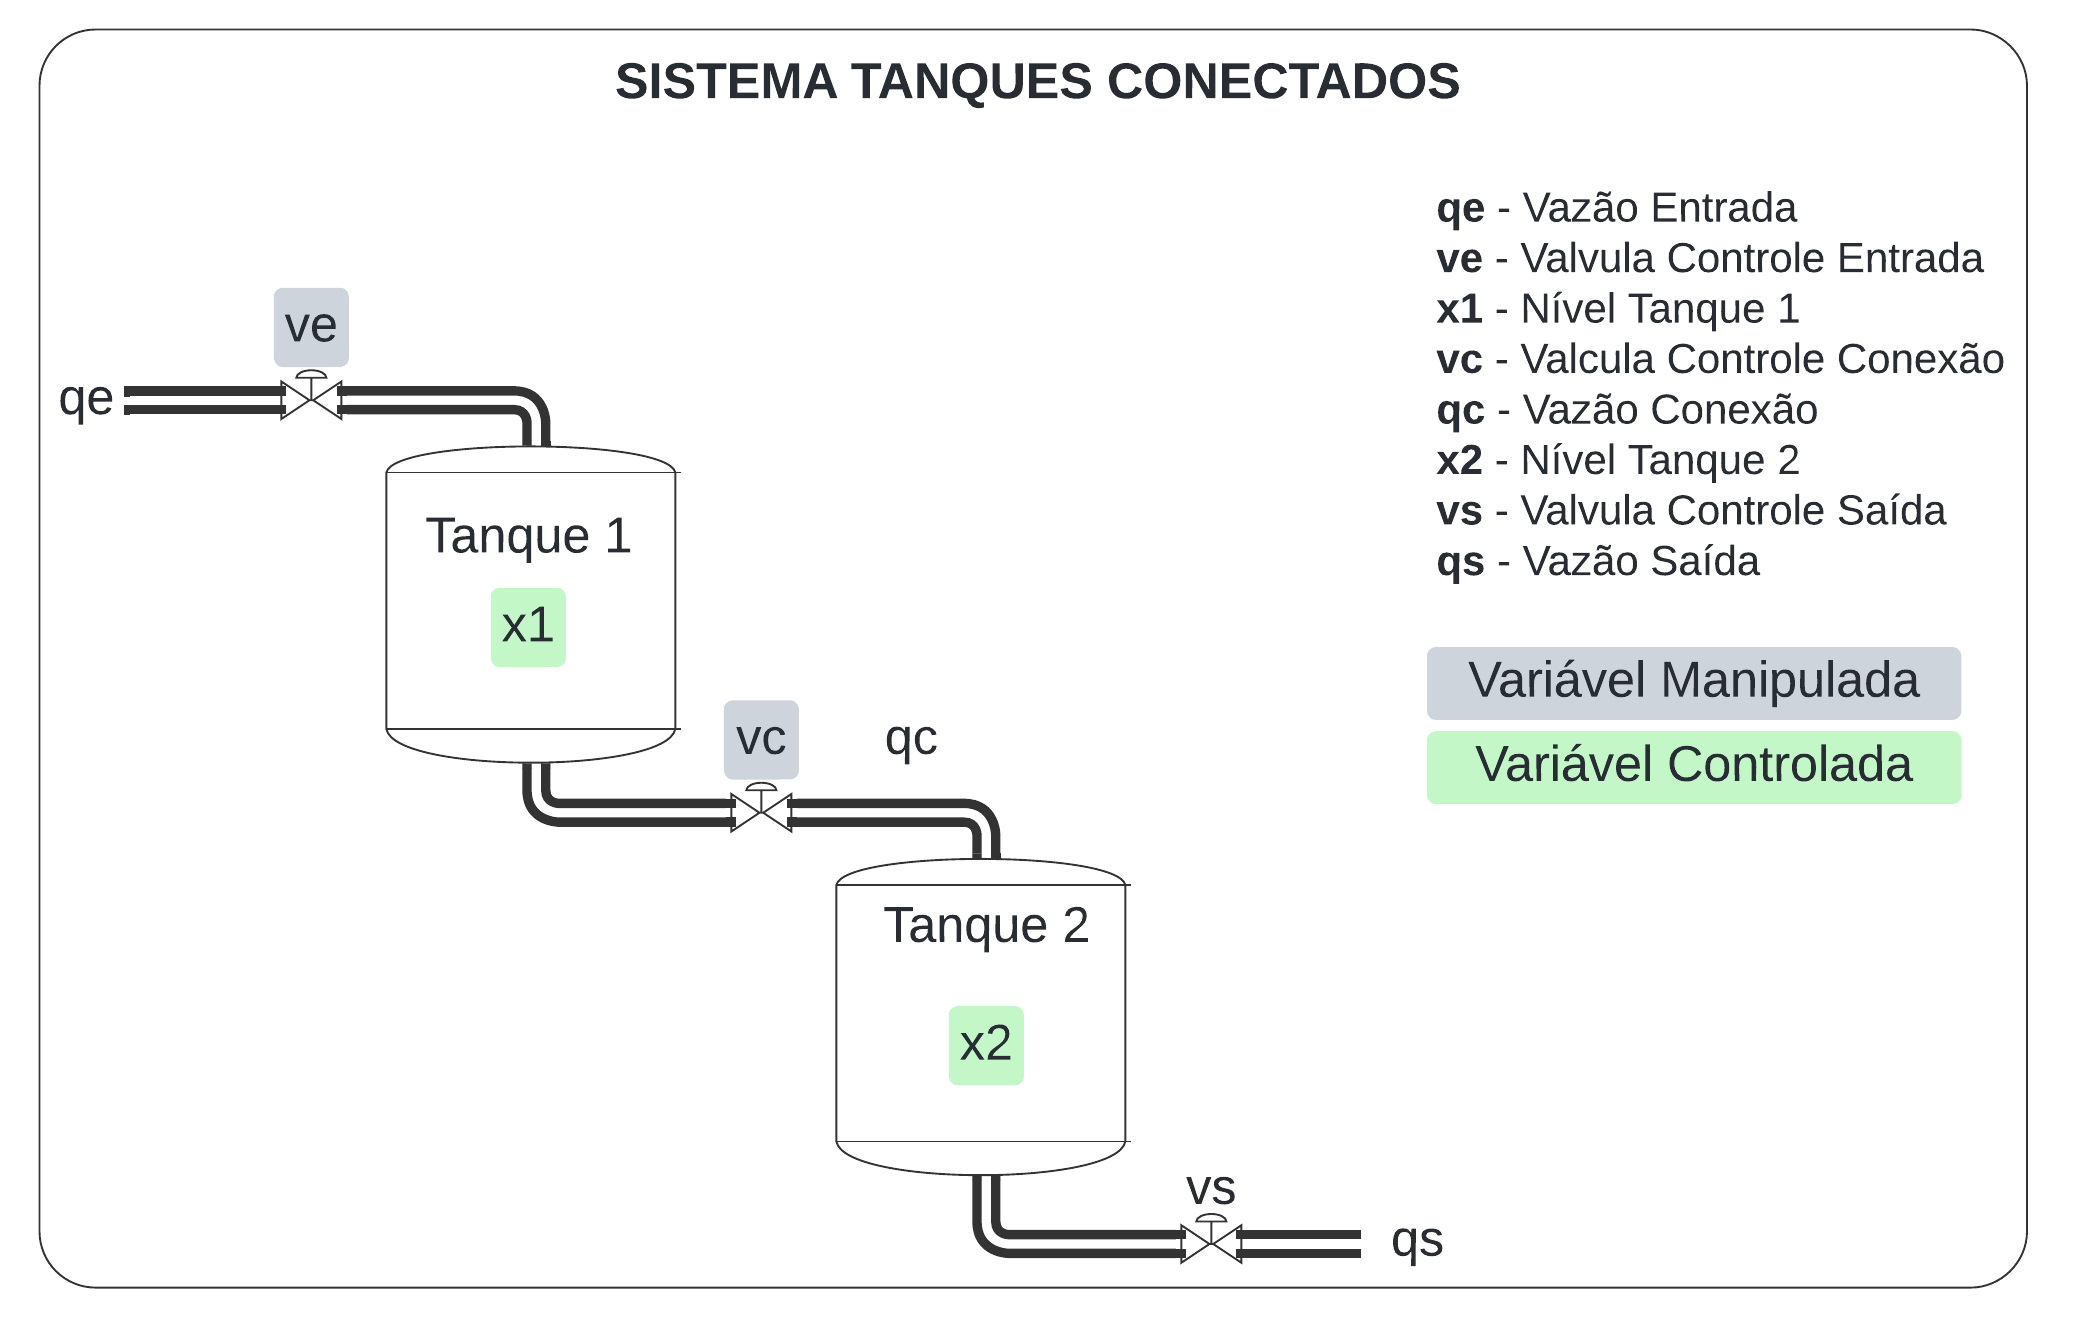

In [49]:
%cd /content/drive/MyDrive/Colab Notebooks/Mestrado/Final

/content/drive/MyDrive/Colab Notebooks/Mestrado/Final


In [50]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
SEED = 1
os.environ['PYTHONHASHSEED']=str(SEED)

import matplotlib.pyplot as plt
from matplotlib import patches
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from pandas import DataFrame, read_csv
import math
from keras import layers
from keras.layers import Input, LSTM, Dense, Reshape, Dropout, Lambda
from keras.models import Model, Sequential, load_model
from functools import partial
import joblib
import warnings

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

tf.keras.backend.set_floatx('float64')
tf.keras.backend.clear_session()

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(SEED)
   tf.random.set_seed(SEED)
   np.random.seed(SEED)
   random.seed(SEED)

reset_random_seeds()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [51]:
def plot_sim_history(sim_history_x1, sim_history_x2):
  plt.figure(figsize=(16, 10))  # Define o tamanho do gráfico

  plt.subplot(3, 1, 1)
  plt.plot(sim_history_x1['x'], label='x1')
  plt.plot(sim_history_x1['ref'], label='ref1', linestyle=':')
  plt.plot(sim_history_x2['x'], label='x2')
  plt.plot(sim_history_x2['ref'], label='ref2', linestyle=':')
  plt.xlabel("Steps/Time(s)")
  plt.ylabel("Level(m)")
  plt.title('Gráfico de Controle Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout

  plt.subplot(3, 1, 2)
  plt.plot(sim_history_x1['qe'], label='qe')
  plt.plot(sim_history_x1['qs'], label='qs')
  plt.ylabel("(m^3/s)")
  plt.title('Gráfico de Sinal Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout


  plt.subplot(3, 1, 3)
  plt.plot(sim_history_x1['erro'], label='erro')
  plt.ylabel("erro (m)")
  plt.title('Gráfico de Erro Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout

  plt.show()

In [52]:
def plotting(history):
    plt.figure(figsize=(16, 4))
    plt.semilogy(history.history['loss'], color = "red")
    plt.semilogy(history.history['val_loss'], color = "blue")
    red_patch = patches.Patch(color='red', label='Training')
    blue_patch = patches.Patch(color='blue', label='Validation')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')

In [53]:
# Criando o gráfico
def plot_sim_degree(sim_degree):
  plt.figure(1, figsize=(16, 4))  # Define o tamanho do gráfico

  #fig, ax = plt.subplots()

  # Plot da variável de controle
  #plt.plot(sim_degree["x1"], label='X1')
  #plt.plot(sim_degree["NN_x1"], label='X1 Rede Neural', linestyle=':')
  plt.scatter(sim_degree["t"], sim_degree["x1"]   , label='X1'            , alpha=0.5)
  plt.scatter(sim_degree["t"], sim_degree["NN_x1"], label='X1 Rede Neural', alpha=1.0, marker='+')

  # Adicionando rótulos aos eixos e título
  plt.xlabel('Tempo')
  plt.ylabel('Nível')
  plt.title('Comportamento Processo x Modelo ao Degrau Unitário - x1')

  # Adicionando legenda
  plt.legend()

  # Exibindo o gráfico
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout


  plt.figure(2, figsize=(16, 4))  # Define o tamanho do gráfico

  #fig, ax = plt.subplots()

  # Plot da variável de controle
  plt.scatter(sim_degree["t"], sim_degree["x2"]   , label='X2'            , alpha=0.5)
  plt.scatter(sim_degree["t"], sim_degree["NN_x2"], label='X2 Rede Neural', alpha=1.0, marker='+')


  # Adicionando rótulos aos eixos e título
  plt.xlabel('Tempo')
  plt.ylabel('Nível')
  plt.title('Comportamento Processo x Modelo ao Degrau Unitário - x2')

  # Adicionando legenda
  plt.legend()

  # Exibindo o gráfico
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout

  plt.show()

Processo que representa um o nível de um tanque com um registro

In [54]:
import math

# Process Const
area = 16
max_level = 12
def tank_xdot(x, qe, valve=100, valve_k = 1):
  if x >= 0:
    qs = valve_k * (valve / 100) * math.sqrt(x)
  else:
    qs = 0
  xd = (qe - qs) / area
  return xd, qs

def tank_rk(x0, qe, valve=100, valve_k = 1, t=0.2):
  a=x0
  b=qe
  c=valve
  #call 1
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  savex0 = x0;
  phi = xd;
  x0 = savex0 + 0.5 * t * xd;

  #call two
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  phi = phi + 2 * xd;
  x0 = savex0 + 0.5 * t * xd;

  #call three
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  phi = phi + 2 * xd;
  x0 = savex0 + t * xd;

  #call four
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  x = savex0 + (phi + xd) * t / 6;

  if x < 0:
    x = 0

  if x > max_level:
    x = max_level

  if np.isnan(x):
    x = 0

  if np.isnan(qs):
    qs = 0

  return x, qs;

In [55]:
pd.set_option('display.max_rows', None)  # Mostrar todas as linhas
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.width', 1000)

In [56]:
# Parametros Globais
np.random.seed(56)
k1 = 2
k2 = 1
ts = 1
vs = 50
horizon = 5
num_data = 10000
data_name = f"NumData-{num_data}_Hor-{horizon}_Ts-{ts}"
data_name

'NumData-10000_Hor-5_Ts-1'

In [57]:
scaler_x_train = joblib.load(f"DataTrain_Scaler-x_{data_name}.pkl")
#scaler_y_train = joblib.load(f"DataTrain_Scaler-y_{data_name}.pkl")
x_train = np.load(f"DataTrain-x_{data_name}.npy")
y_train = np.load(f"DataTrain-y_{data_name}.npy")

Modelo de Rede Neural

In [58]:
model = Sequential()
model.add(Lambda(lambda x: x[:]))
model.add(Dense(32, activation=partial(tf.nn.leaky_relu, alpha=0.5)))
model.add(Dense(64, activation=partial(tf.nn.leaky_relu, alpha=0.5)))
model.add(Dense(2, kernel_initializer=tf.initializers.zeros))

In [59]:
lr=0.001
optimizer = tf.optimizers.Adam(learning_rate=lr)
loss=tf.losses.MeanSquaredError()
metrics=[tf.metrics.MeanSquaredError()]
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora a métrica de validação
    patience=15,  # Número de épocas sem melhoria antes de parar
    restore_best_weights=True  # Restaura os pesos do modelo à melhor época
)

In [61]:
num_epochs=200
num_batch_size=10
history = model.fit(
            x = x_train,
            y = y_train,
            batch_size = num_batch_size,
            epochs = num_epochs,
            verbose = 1,
            callbacks=[early_stopping],
            validation_split = 0.2
          )
history

Epoch 1/200
800/800 [==============================] - 3s 3ms/step - loss: 0.0601 - mean_squared_error: 0.0601 - val_loss: 0.0390 - val_mean_squared_error: 0.0390
Epoch 2/200
800/800 [==============================] - 4s 5ms/step - loss: 0.0352 - mean_squared_error: 0.0352 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 3/200
800/800 [==============================] - 5s 7ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 4/200
800/800 [==============================] - 4s 5ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0270 - val_mean_squared_error: 0.0270
Epoch 5/200
800/800 [==============================] - 5s 6ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 6/200
800/800 [==============================] - 8s 10ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0144 - val_mean_squared_error: 0.0144
Epoch 7/200
800/800 [

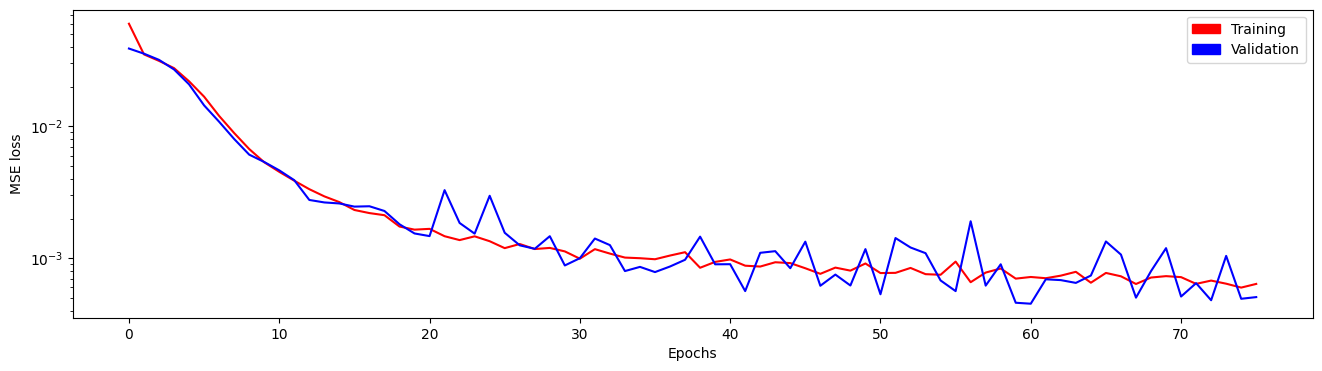

In [62]:
plotting(history)

Simulação Degrau Unitário para verificar se a rede neural tem comportamento semelhante ao processo.

In [63]:
sim_degree_columns = ["t","qe", "qc", "qs", "x1", "x2", "NN_x1", "NN_x2"]
sim_degree = np.zeros((1,len(sim_degree_columns)))

pred_nn_columns = ["qe", "qc", "qs", "NN_x[0]", "NN_x[1]", "diff2[0]", "diff2[1]", "NN_pred[0]", "NN_pred[1]"]
pred_nn = np.zeros((1,len(pred_nn_columns)))

qe = 2.0;
vc = 100
t = 0

for l in range(13):
  t+=1

  x = [l, l];
  NN_x =  [l, l];

  NN_in = np.array([[NN_x[0], qe, vc, NN_x[1], vs]])
  NN_in = scaler_x_train.transform(NN_in)
  NN_pred = model.predict(NN_in, verbose = None);
  #NN_pred = scaler_y_train.inverse_transform(NN_pred)
  NN_x[0] += NN_pred[0][0]
  NN_x[1] += NN_pred[0][1]

  for _ in range(horizon):
    x[0], qc = tank_rk(x[0], qe, vc, k1, ts)
    x[1], qs = tank_rk(x[1], qc, vs, k2, ts)

  sim_degree = np.vstack((sim_degree, (t, qe, qc, qs, x[0], x[1], NN_x[0], NN_x[1])))
sim_degree = pd.DataFrame(data = sim_degree, columns = sim_degree_columns)
pred_nn = pd.DataFrame(data = pred_nn, columns = pred_nn_columns)
sim_degree

,t,qe,qc,qs,x1,x2,NN_x1,NN_x2
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,2.0,1.195936,0.249408,0.357526,0.248822,0.298315,0.277504
2,2.0,2.0,2.000000,0.602505,1.000000,1.452049,1.047244,1.426733
3,3.0,2.0,2.659498,0.808395,1.768242,2.614007,1.795855,2.586090
4,4.0,2.0,3.213896,0.967947,2.582294,3.747686,2.594706,3.737662
5,5.0,2.0,3.700010,1.102716,3.422532,4.863932,3.447848,4.833764
6,6.0,2.0,4.137766,1.221488,4.280290,5.968127,4.309850,5.932061
7,7.0,2.0,4.539082,1.328850,5.150829,7.063367,5.161399,7.061599
8,8.0,2.0,4.911705,1.427552,6.031224,8.151618,6.027741,8.163066
9,9.0,2.0,5.260991,1.519393,6.919519,9.234219,6.924142,9.233815


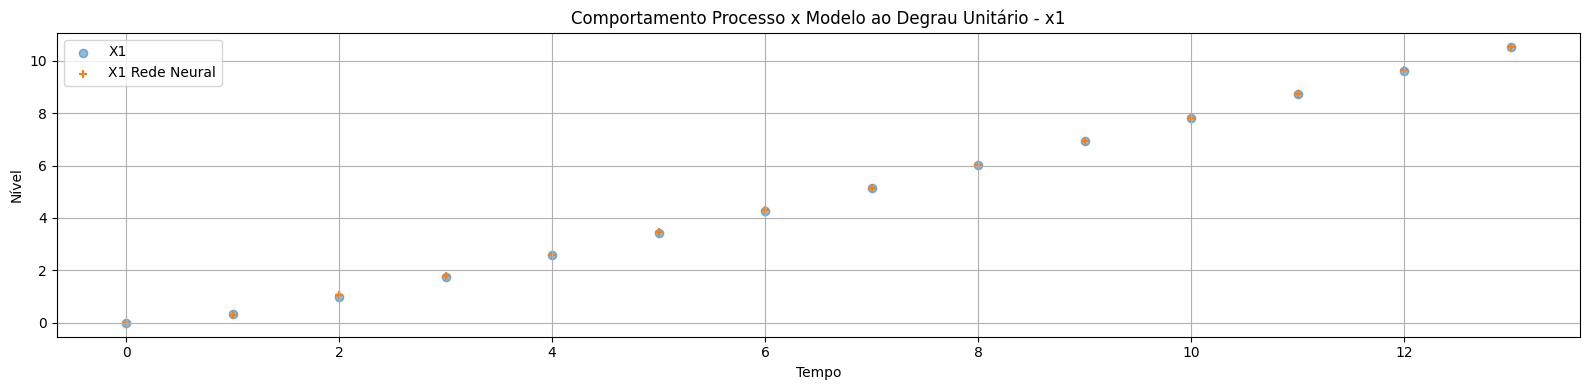

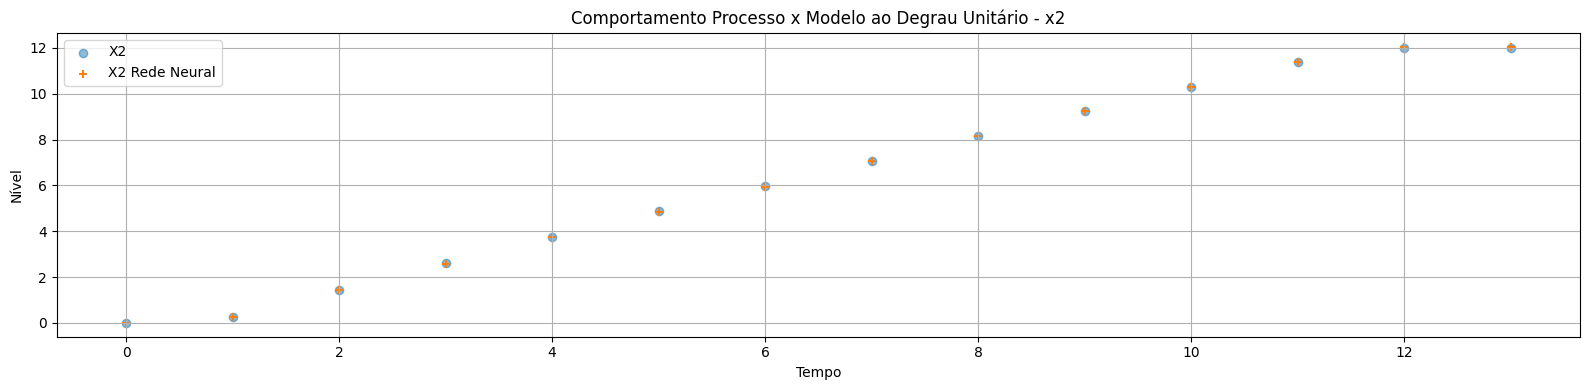

In [64]:
 plot_sim_degree(sim_degree)

In [65]:
model.save_weights(f"Model-Weights_{data_name}")

In [67]:
model.save_weights(f"Model-Weights_{data_name}/Model")